<a href="https://colab.research.google.com/github/Ashu156/Neural-time-series-analysis-LFP/blob/main/tf_decomposition_using_mne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

import mne
import numpy as np

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from mne import create_info, EpochsArray
from mne.baseline import rescale
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet,
                                tfr_array_morlet)
from mne.viz import centers_to_edges

print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
# Import data file from local machine
from google.colab import files
uploaded = files.upload()

Saving fear_recall.mat to fear_recall (1).mat


In [6]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt

from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle  #import basic functions from numpy that we'll need
from numpy.fft import fft, ifft

In [7]:
data = scipy.io.loadmat('fear_recall.mat')
raw_data = data['CSC28_DP']
raw_times = data['CSC28_TS']
raw_events = data['Events_PIPS'] / 1000000.

In [8]:
raw_info = data['CSC28_NlxHeader']
ADBitVolts = float(raw_info[14][0][0][12:37])
sfreq = float(raw_info[13][0][0][-17:-1])
print(ADBitVolts, sfreq)

3.0518510385491e-08 1017.26165877229


In [10]:
import scipy.signal
dp_csc = raw_data * ADBitVolts
n_trials = raw_events.shape[1]
ts_csc = raw_times / 1000000.
dp_csc = dp_csc.flatten()
dp_csc = scipy.signal.detrend(dp_csc, axis = -1, type = 'constant')

In [11]:
tts_csc = np.linspace(ts_csc[0, 0], ts_csc[0, -1], len(dp_csc))

In [12]:
def closest(X, p):
    disp = X - p
    return np.argmin((disp*disp))
ind = []
for i in range(n_trials):
  idx = closest(tts_csc, raw_events[0,i])
  ind.append(idx)

In [13]:
lfp = []
increment = int(sfreq/2)
for k in range (n_trials):
  start_idx = ind[k]
  signal = dp_csc[start_idx - increment: start_idx + increment]
  lfp.append(signal)
lfp = np.array(lfp)

In [14]:
event_id = dict(CS = 1)
data_for_mne = np.reshape(lfp, [n_trials, 1, lfp.shape[1]], order = "F")

In [15]:
n_channels = len(data_for_mne[1,:,1])
chan_names = ["CSC28"] 
# Initialize an info structure
info = mne.create_info(
        ch_names = chan_names,
        ch_types = ['eeg']*n_channels,
        sfreq    = sfreq 
        )  
print('Event created :', info)    

Event created : <Info | 7 non-empty values
 bads: []
 ch_names: CSC28
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 508.6 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 1017.3 Hz
>


In [16]:
# Create an event matrix: events with alternating event codes
eventLength = n_trials
ev = [i*sfreq*3 for i in range(eventLength)]

labels = np.ones(90, dtype = int)

events = np.column_stack((np.array(ev),
                          np.zeros(eventLength,  dtype = int),
                          np.array(labels)))

events = np.array(events, dtype = int)

In [17]:
events.dtype

dtype('int64')

In [18]:
tmin = 0                
        # Create the :class:`mne.EpochsArray` object
epochs = mne.EpochsArray(data_for_mne, info, events, tmin, event_id)

Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


Need more than one channel to make topography for eeg. Disabling interactivity.


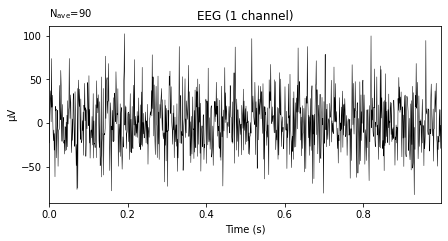

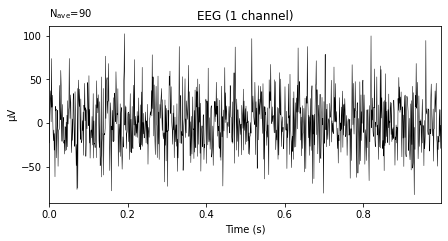

In [19]:
# quick visualization 
epochs.average().plot()

    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-20-697022bd73f1>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()


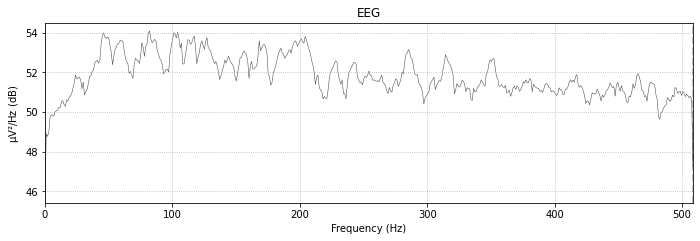

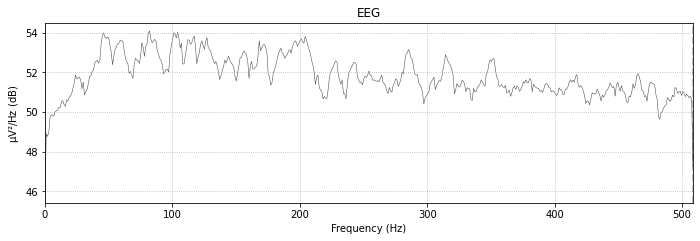

In [20]:
epochs.plot_psd()

Applying baseline correction (mode: zscore)


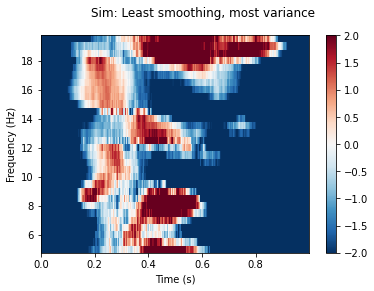

[<Figure size 432x288 with 2 Axes>]

In [21]:
# Multitaper transform
freqs = np.arange(5., 20., 0.5)
vmin, vmax = -2., 2.  # Define our color limits.

# 1. Least smoothing (most variance / background fluctuations)
n_cycles = freqs / 2.
time_bandwidth = 2.0  # Least possible frequency-smoothing (1 taper)
power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                       time_bandwidth=time_bandwidth, return_itc=False)
# Plot results. Baseline correct based on first 100 ms.
power.plot([0], baseline=(0.2, 0.4), mode='zscore', vmin=vmin, vmax=vmax,
           title='Sim: Least smoothing, most variance')

Applying baseline correction (mode: zscore)


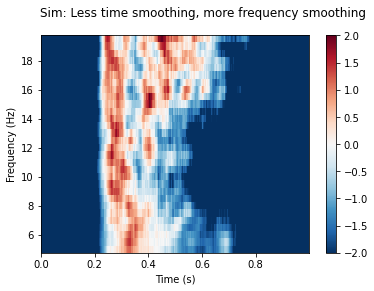

[<Figure size 432x288 with 2 Axes>]

In [22]:
# 2. Less time smoothing, more frequency smoothing
n_cycles = freqs / 2.
time_bandwidth = 8.0  # Same time-smoothing as (1), 7 tapers.
power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                       time_bandwidth=time_bandwidth, return_itc=False)
# Plot results. Baseline correct based on first 100 ms.
power.plot([0], baseline=(0.2, 0.4), mode='zscore',  vmin = -2, vmax = 2,
           title='Sim: Less time smoothing, more frequency smoothing')

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


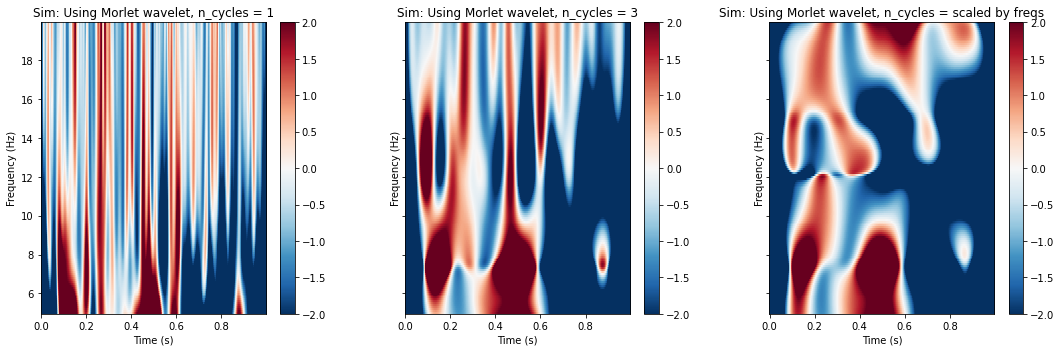

In [23]:
# Morlet wavelets
freqs = np.arange(5., 20., 0.1)
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
all_n_cycles = [1, 3, freqs / 2.]
for n_cycles, ax in zip(all_n_cycles, axs):
    power = tfr_morlet(epochs, freqs=freqs, 
                       n_cycles=n_cycles, return_itc=False)
    power.plot([0], baseline=(0.2, 0.4), mode='zscore', vmin = -2, vmax = 2, 
               axes=ax, show=False, colorbar=True)
    n_cycles = 'scaled by freqs' if not isinstance(n_cycles, int) else n_cycles
    ax.set_title('Sim: Using Morlet wavelet, n_cycles = %s' % n_cycles)
plt.tight_layout()

Applying baseline correction (mode: zscore)


<ipython-input-25-5f59c9f2d62e>:5: RuntimeWarning: The input signal is shorter (1016) than "n_fft" (1024). Applying zero padding.
  power = tfr_stockwell(epochs, fmin=fmin, fmax=fmax, width=width)
<ipython-input-25-5f59c9f2d62e>:5: RuntimeWarning: The input signal is shorter (1016) than "n_fft" (1024). Applying zero padding.
  power = tfr_stockwell(epochs, fmin=fmin, fmax=fmax, width=width)


Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


<ipython-input-25-5f59c9f2d62e>:5: RuntimeWarning: The input signal is shorter (1016) than "n_fft" (1024). Applying zero padding.
  power = tfr_stockwell(epochs, fmin=fmin, fmax=fmax, width=width)


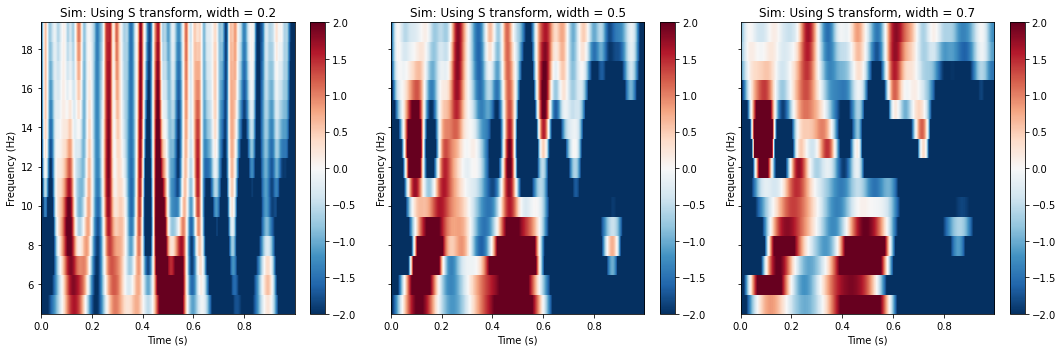

In [25]:
# Stockwell transform
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fmin, fmax = freqs[[0, -1]]
for width, ax in zip((0.2, 0.5, 0.7), axs):
    power = tfr_stockwell(epochs, fmin=fmin, fmax=fmax, width=width)
    power.plot([0], baseline=(0.2, 0.4), mode='zscore', vmin = -2, vmax = 2, axes=ax, show=False,
               colorbar=True)
    ax.set_title('Sim: Using S transform, width = {:0.1f}'.format(width))
plt.tight_layout()